# Guía 0 - Análisis exploratorio de datos
## Descarga y exploración de una DB para el análisis de sus datos

En general, toda búsqueda de información o proceso de descubrimiento comienza con un problema o una pregunta. Usualmente, también traemos ideas previas o tentativas que de alguna manera trataremos de confirmar, ampliar o rectificar. En resumen, el análisis de datos nos exige antes comprender claramente que representan, conocer cómo se generaron y qué reglas aplican para luego poder interpretarlos y avanzar en modelos de predicción o pronóstico.

Actualmente, la oferta de datos es inmensa dado el progreso y abaratamiento de los instrumentos de medición, la mayor capacidad de almacenamiento y comunicación. Asimismo, las políticas de datos abiertos (Open Data) alentadas por la comunidad científica, asimiladas por muchas empresas y sostenidas por las iniciativas de Gobierno Abierto han contribuído a la abundancia de datos y su interés por la creación de más valor a través de su reutilización.

## Estudio de caso: serie 2017-2025 de demanda eléctrica diaria en Argentina 

Dentro de este contexto tecnológico e institucional y a modo de ejemplo, tomaremos los datos publicados por Cammesa para ejercitarnos en las técnicas de análisis y modelado de series temporales que iremos incorporando en sucesivos estudios de casos. La Compañía Administradora del Mercado Mayorista Eléctrico Sociedad Anónima (CAMMESA) coordina las operaciones de despacho, la responsabilidad por el establecimiento de los precios mayoristas y la administración de las transacciones económicas que se realizan a través del Sistema Argentino de Interconexión (SADI). 

Captura de pantalla del sitio web de Cammesa: 
![Captura de pantalla del sitio web de Cammesa](Figs/cammesa_sitio_web_2026.png)

La propuesta es descragar la DB que contiene información histórica entre los años 2017 y 2025 para la demanda neta eléctrica diaria en Argentina.

Captura de pantalla del sitio web de Cammesa con el enlace para la [descarga](https://cammesaweb.cammesa.com/2026/01/05/covid-19-comportamiento-de-la-demanda-de-energia-electrica-en-el-mem/#) de las DB: 
![Captura de pantalla del sitio de descarga de los datos de Cammesa](Figs/cammesa_db_2017_2025.png)

Luego de descomprimir el archivo podemos desplegar la planilla que contiene diferentes solapas. Particularmente, estamos interesados en la solapa `Datos Región`. 

Captura de pantalla del contenido del archivo `'Base Demanda Diaria 2017 2025.xlsx` desplegado en una hoja de cálculo: 
![Captura de pantalla de la hoja de cálculo desplegando la planilla](Figs/cammesa_planilla_2017_2023.png) 


### Primer contacto con los datos

Comnezamos cargando la hoja con los datos de interés y visualizamos sus primeros registros


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

baseDiaria = pd.read_excel('Data/Base Demanda Diaria 2017 2025.xlsx',
                           sheet_name='Datos Región', skiprows=4)

baseDiaria.head()

,AÑO,MES,Fecha,Tipo día,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,COMAHUE,PATAGONICA,DEMANDA TOTAL,TEMPERATURA REFERENCIA MEDIA GBA °C
0,2017,2017-01-01,2017-01-01,Domingo o Feriado,6352.695208,1472.270500,1134.394250,1766.623958,903.135875,1602.126625,1400.333417,561.243208,500.863042,15693.686083,31.30
1,2017,2017-01-01,2017-01-02,Lunes habiles,6617.863750,1779.435208,1363.527292,1963.925833,1091.811167,1627.567250,1585.616708,638.835167,540.577750,17209.160125,25.35
2,2017,2017-01-01,2017-01-03,Martes Habiles,6677.996167,1888.984333,1600.744625,2036.345917,1178.718583,1806.474000,1652.989833,624.649083,536.472333,18003.374875,25.45
3,2017,2017-01-01,2017-01-04,Miercoles habiles,6426.997625,1840.623833,1356.381292,1756.640500,1078.903250,1759.855667,1604.750375,598.400500,528.904083,16951.457125,27.00
4,2017,2017-01-01,2017-01-05,Jueves Habiles,5873.950750,1770.942583,1366.018917,1848.409375,1037.791833,1403.490042,1228.303125,585.206708,524.657125,15638.770458,21.90


Conocemos el nombre o encabezado de las columnas y profundizamos en el tipo de dato que almacenan al igual que su tamaño.

In [40]:
baseDiaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256 entries, 0 to 3255
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   AÑO                                  3256 non-null   int64         
 1   MES                                  3256 non-null   datetime64[ns]
 2   Fecha                                3256 non-null   datetime64[ns]
 3   Tipo día                             3256 non-null   object        
 4   GRAN BS.AS.                          3256 non-null   float64       
 5   BUENOS AIRES                         3256 non-null   float64       
 6   CENTRO                               3256 non-null   float64       
 7   LITORAL                              3256 non-null   float64       
 8   CUYO                                 3256 non-null   float64       
 9   NOROESTE                             3256 non-null   float64       
 10  NORESTE     

Es interesante notar que la columna fecha ya se detectó y codificó correctamente como tipo de dato `datetime64[ns]`. Si bien esta *característica o feature* permite conocer el día de la semana,

In [41]:
baseDiaria['Fecha'].dt.day_name()

0          Sunday
1          Monday
2         Tuesday
3       Wednesday
4        Thursday
          ...    
3251    Wednesday
3252     Thursday
3253       Friday
3254     Saturday
3255       Sunday
Name: Fecha, Length: 3256, dtype: object

es trabajoso recuperar los días feriados. Por eso, nos quedamos con la columna `Tipo día`

In [42]:
baseDiaria['Tipo día'].value_counts()

Tipo día
Domingo o Feriado         608
Sabado o Semilaborable    466
Miercoles habiles         453
Jueves Habiles            448
Martes Habiles            442
Viernes habiles           431
Lunes habiles             408
Name: count, dtype: int64

En adelante, nos limitamos a los atributos que usaremos en el estudio de la demanda eléctrica. Además, definimos el índice para facilitar los cálculos de distancias entre fechas

In [43]:
baseDiaria.set_index(pd.to_datetime(baseDiaria['Fecha']),inplace=True)
baseDiaria = baseDiaria[['DEMANDA TOTAL', 'Tipo día', 'TEMPERATURA REFERENCIA MEDIA GBA °C']]
baseDiaria.rename(columns={'TEMPERATURA REFERENCIA MEDIA GBA °C':'TEMP MEDIA'}, inplace=True)
baseDiaria['Interval'] = np.float32((baseDiaria.index - baseDiaria.index[0]).days)

**Ejercicios**
1. Confirmar que no faltan fechas ni valores en la base de datos diaria.
2. Buscar el mínimo de demanda eléctrica total y **Googlear que pasó ese día**.
3. Representar `DEMANDA TOTAL` en función de la `Fecha`. Observar la presencia de un patrón de mínimos y máximos que se repiten todos los años.
4. Representar `DEMANDA TOTAL` en función de `TEMP MEDIA`.
5. Realizar un *boxplot* de `DEMANDA TOTAL` según `Tipo día`.
6. Proponer modelos *benchmarks* que estimen la 'DEMANDA TOTAL'. Se busca fijar un nivel de acuerdo mínimo contra el cual comparar a los próximos modelos más avanzados. Obtener métricas como el coeficiente de determinación, MAE, RMSE, entre otras opciones.  
    a. Un modelo que siempre predice la media de la serie.  
    b. Un modelo que siempre predice el valor del día anterior.  
    c. Un modelo que siempre predice el valor del mismo día de la semana anterior.


**Respuestas**

Al utilizar el método `asfreq()` en `Pandas`, cualquier espacio en la serie temporal se rellenará con valores NaN para que coincidan con la frecuencia especificada. Para comprobar si hay valores faltantes que puedan producirse después de esta transformación

In [44]:
baseDiaria.asfreq('D')
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {baseDiaria.isna().any().sum()}')

Number of rows with missing values: 0


Aunque no es necesario, ya que se ha establecido una frecuencia, es posible verificar que la serie temporal está completa.

In [45]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = baseDiaria.index.min()
end_date = baseDiaria.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=baseDiaria.index.freq)
is_index_complete = (baseDiaria.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


Text(0, 0.5, 'DEMANDA TOTAL (MW)')

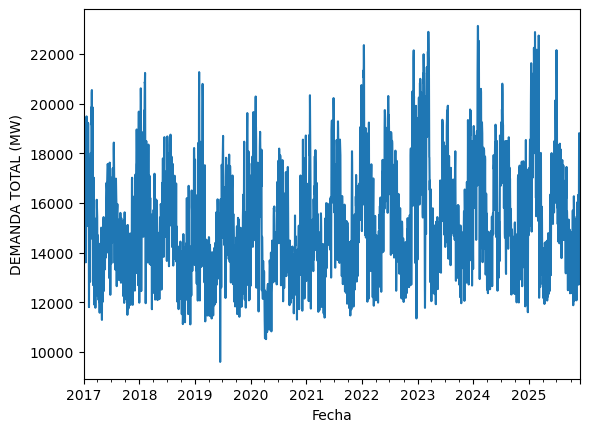

In [46]:
import matplotlib.pyplot as plt
baseDiaria['DEMANDA TOTAL'].plot()
plt.ylabel('DEMANDA TOTAL (MW)')

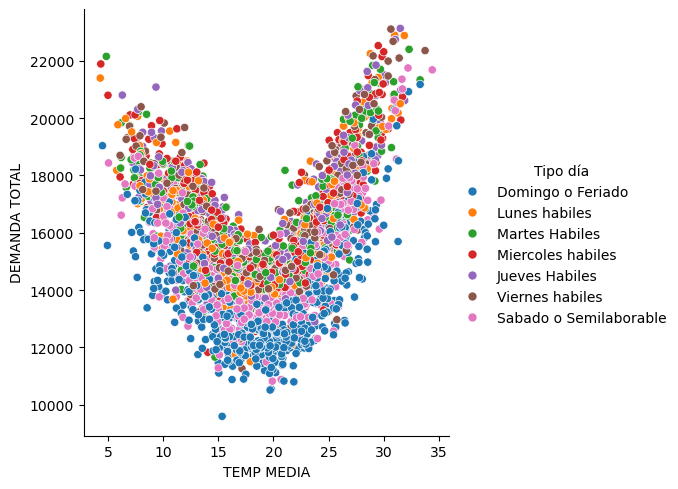

In [47]:
import seaborn as sns

sns.relplot(
    data=baseDiaria,
    x='TEMP MEDIA', y='DEMANDA TOTAL', hue='Tipo día'
)

<Axes: xlabel='Tipo día', ylabel='DEMANDA TOTAL'>

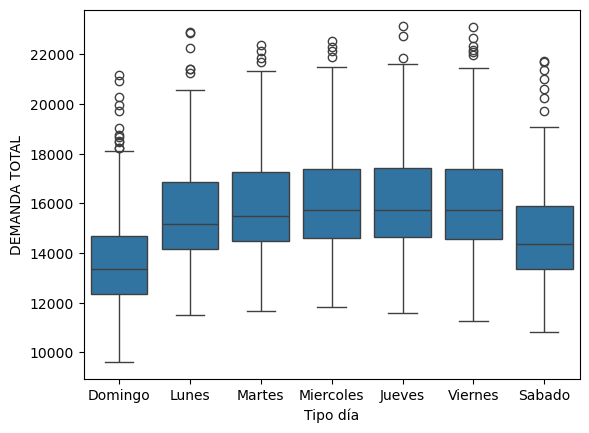

In [48]:
sns.boxplot(
    data=baseDiaria,
    x='Tipo día', y='DEMANDA TOTAL', formatter=(lambda x: x.split()[0])
)

In [49]:
print('a. Modelo que predice la media')
print(f'La media es {np.mean(baseDiaria['DEMANDA TOTAL']):.0f}MW')
print(f'La varianza para el modelo que predice la media es {np.sqrt(np.var(baseDiaria['DEMANDA TOTAL'])):.0f}MW')

print('b. Modelo que predice repitiendo el valor del día anterior')
print(f'La varianza para el residuo del modelo que repite el valor de ayer es  \
{np.sqrt(np.var(baseDiaria['DEMANDA TOTAL']- baseDiaria['DEMANDA TOTAL'].shift(1))):.0f}MW')

a. Modelo que predice la media
La media es 15404MW
La varianza para el modelo que predice la media es 2113MW
b. Modelo que predice repitiendo el valor del día anterior
La varianza para el residuo del modelo que repite el valor de ayer es  1307MW
